## Relevant Changes
Run this script on all 3 data sets  
Sample 25 seeds and calculate a rank for every variable  
store these ranks and compute the average score at the end of 25 trials  
plot these ranks and their standard errors  

# Adamy Valuation - Michigan Data Science Team
### Michael Xinyu Tim Sid Derek Manny
                                                                                                        5/06/2017

**Purpose:** This notebook describes the data processing pipeline we have built and instructions on how to interpret the results.  
  
**Conclusion:** Ebitda/interest_exp is the best predictor of ev/ebidta. It seems that the higher the ebitda/interest_exp the lower our prediction for ev/ebitda. Other important features are ebitda_margin and ebitda.  
  
**Notes:** It was hard to precisely quantify the degree to which these variables actually impacted ev/ebitda because of the limitations of linear regression. We have provided several lists of features that our models found to be important. It would be interesting to compare and contrast these lists with the existing literature. 

## Load Libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from get_data import *

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats as stats
import random
from mpl_toolkits.mplot3d import Axes3D
from get_data import *

# SciKit Learn Modules
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

## Load Data

In [3]:
np.random.seed(0)
raw_data_frame = load_data_frames()
sectors = ['consumerDiscrete', 'consumerStaples', 'industrials']

Our exploratory data anlaysis led us to discover that our models would be more effective after transforming some of the columns. Specifically those columns that represent monetary values as well as a few others.

In [4]:
for i in range(len(raw_data_frame[0].columns)):
    print(i, raw_data_frame[0].columns[i])

(0, 't_ev')
(1, 't_rev')
(2, 'ebitda')
(3, 'ebitda_margin')
(4, 't_ev/t_rev')
(5, 't_ev/ebitda')
(6, 'est_ann_rev_gr_1yr')
(7, 'est_ann_ebitda_gr_1yr')
(8, 't_rev_1yr_growth')
(9, 'ebitda_1yr_growth')
(10, 't_rev_3_yr_cagr')
(11, 'ebitda_3yr_cagr')
(12, 't_rev_5yr_cagr')
(13, 'ebitda_5yr_cagr')
(14, 'return_on_assets')
(15, 'return_on_equity')
(16, 'capex_as_percent_rev')
(17, 'ebitda/interest_exp')
(18, 't_debt/cap_percent')
(19, 't_debt/equity_percent')


In [5]:
log_transform_columns =  [0, 1, 2, 5, 16, 17, 18, 19]
log_transform_col_names = []
for col in log_transform_columns:
    log_transform_col_names.append(raw_data_frame[0].columns[col])
print log_transform_col_names

['t_ev', 't_rev', 'ebitda', 't_ev/ebitda', 'capex_as_percent_rev', 'ebitda/interest_exp', 't_debt/cap_percent', 't_debt/equity_percent']


We need to actually modify the data for the columns we discovered.  
**Note:** Because we do the following process in place it is important that the line is not run twice.

In [6]:
# log-transform inplace
for i in range(len(sectors)):
    raw_data_frame[i][log_transform_col_names] = raw_data_frame[i][log_transform_col_names].apply(np.log10)
    raw_data_frame[i].rename(columns = {
        't_ev':'log_t_ev',
        't_rev':'log_t_rev',
        'ebitda':'log_ebitda',
        't_ev/ebitda':'log_t_ev/ebitda',
        'capex_as_percent_rev':'log_capex_as_percent_rev',
        'ebitda/interest_exp':'log_ebitda/interest_exp',
        't_debt/cap_percent':'log_t_debt/cap_percent',
        't_debt/equity_percent':'log_t_debt/equity_percent'
                                },inplace = True)    

In order to handle missing data we fill in cells the with mean for the column

In [7]:
for i in range(len(sectors)):
    raw_data_frame[i].fillna(raw_data_frame[i].mean(), inplace=True)

## Prepare the data for ML models

- Target: 't_ev/ebitda'
- Discard 't_ev'

From pearson correlation heatmap, we see that target variable is not strongly linearly associated with other features. Therefore, the nonlinear methods, like tree-based methods, or SVM with nonlinear kernels will outperform. However, one thing to notice is that our final goal is not to predict the target value but rather to understand the complex relationship between ev/ebitda and other features. We shall try various methods  
  
We chose to discared the feature t_ev and t_ev/t_rev because we believe it will not be known for a private company

In [8]:
# drop 't_ev' columns
for i in range(len(sectors)):
    raw_data_frame[i].drop('log_t_ev', axis=1, inplace=True)
    raw_data_frame[i].drop('t_ev/t_rev', axis=1, inplace=True)

In [9]:
print("Let's look at " + sectors[1])
cur_df = raw_data_frame[1]

Let's look at consumerStaples


In [10]:
y = cur_df['log_t_ev/ebitda']
X = cur_df.drop('log_t_ev/ebitda', axis=1)
X.head()

,log_t_rev,log_ebitda,ebitda_margin,est_ann_rev_gr_1yr,est_ann_ebitda_gr_1yr,t_rev_1yr_growth,ebitda_1yr_growth,t_rev_3_yr_cagr,ebitda_3yr_cagr,t_rev_5yr_cagr,ebitda_5yr_cagr,return_on_assets,return_on_equity,log_capex_as_percent_rev,log_ebitda/interest_exp,log_t_debt/cap_percent,log_t_debt/equity_percent
0,3.188900,2.372544,15.30,5.653093,9.992372,9.500577,22.651782,6.045785,9.478606,5.870128,8.05713,7.969986,39.362728,0.348305,0.423246,2.180126,1.736516
1,0.093422,-0.018634,77.30,5.653093,9.992372,29.300000,22.651782,-0.599000,9.478606,4.900000,8.05713,46.400000,39.362728,-0.522879,0.330414,1.476933,1.736516
2,2.158965,1.578639,26.20,5.653093,9.992372,-5.830000,-4.970000,12.400000,17.300000,7.900000,10.90000,3.060000,3.930000,0.996512,0.583199,1.725912,2.056142
3,3.272770,2.062206,6.16,5.653093,9.992372,-1.470000,-4.660000,-7.840000,-8.340000,-0.484000,-0.06900,2.670000,34.000000,-0.044312,-0.028260,1.922206,2.706206
4,4.286299,3.975294,48.90,2.900000,5.650000,3.180000,8.190000,2.950000,6.400000,3.330000,6.83000,17.800000,176.800000,0.086360,1.086360,1.911690,2.647383


It is common practice in Machine Learning to use inputs of mean = 0 and standard deviation = 1. This way the impact of the features can be compared head to head. The scale() function below does this transformation

In [11]:
from sklearn.preprocessing import scale
X_scale = scale(X)

Before we start doing any model selection it is important that we break our data up into a training and a test set. The training set will be used to select and train the models. The test set will come in at the end of the program and will be our way of testing a models accuracy on data that is has never seen.  
The training set will consist of 75% of our data and the test set will have the remaining 25%. Each set has an "X" and "y" component. The y component is what we are trying to predict, t_ev/ebitda. The X component consists of all other variables in the data set (ebitda, ebitda_margin, est_ann_rev_gr_1yr, etc.) which we will be using to predict t_ev/ebitda.

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X_scale,y,train_size = 0.75)

## Random Forest Classifier

In [13]:
# basic model 
model = RandomForestRegressor()
scores = cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=5)
# print('MSEs:', scores*-1)
print("Average MSE: %0.4f (+/- %0.4f)" % (-scores.mean(), scores.std()))

Average MSE: 0.0603 (+/- 0.0190)


There are a bunch of 'tuning parameters' for random forest. One commonly used method is to just try a bunch of combinations and take the the one that works best.

In [14]:
from sklearn.ensemble import RandomForestRegressor
from itertools import product
n_estimators_params = [10, 20]
max_features_params = ['auto', 'sqrt', "log2"]
min_samples_split_params = [2]
min_samples_leaf_params = [  2]

result_dict = {}
for param in product(n_estimators_params, max_features_params, min_samples_split_params, min_samples_leaf_params):
    rf_model = RandomForestRegressor(n_estimators=param[0], max_features=param[1],
                                min_samples_split=param[2], min_samples_leaf=param[3], 
                                 random_state=1711, n_jobs=-1)
    scores = cross_val_score(rf_model, x_train, y_train, scoring='neg_mean_squared_error', cv=5)
    result_dict[param] = (-scores.mean(), scores.std())
#     print 'current param: n_estimators_params, max_features_params, min_samples_split_params, min_samples_leaf_params'
#     print param
#     print 'mse mean and std: ',  -scores.mean(), scores.std()

In [15]:
min_mse = 100
min_param = ()
for param in result_dict:
    if result_dict[param][0] < min_mse:
        min_mse=result_dict[param][0]
        min_param = param
print result_dict[min_param], min_param

(0.058330045850789547, 0.019168722743973656) (20, 'auto', 2, 2)


We found that the optimal model uses 20 estimators, 'auto' feature parameters, and will split a minimum of 2 times and leave a minimum of 2 leafs. It is not useful to go into precise defintions of what these terms means. The implications are not clear. We want to focus on the feature importance that will come out as a result.

In [26]:
cumulative_winnings = []
np.random.seed(212)
for j in range(100):
    seed = np.random.randint(0,10**4)
    x_train, x_test, y_train, y_test = train_test_split(X_scale,y,train_size = 0.75)
    rf_model = RandomForestRegressor(n_estimators=20, max_features='auto',
                                    min_samples_split=2, min_samples_leaf=2,random_state=seed, n_jobs=-1)

    rf_model.fit(x_train, y_train)
    yhat_rf = rf_model.predict(x_test)
    #print 'Finished!'
    feature_importance = rf_model.feature_importances_
 
    rf_feat_pairs = []

    for i in range(len(feature_importance)):
        rf_feat_pairs.append((X.columns[i],feature_importance[i]))     
        cumulative_winnings.append((X.columns[i],feature_importance[i]))


# Now I need to average over all instances of column to compute avg score    


In [27]:
df = pd.DataFrame()


for i in range(len(X.columns)):
    rankings = []
    for j in range(len(cumulative_winnings)):
        if X.columns[i] == cumulative_winnings[j][0]:
            rankings.append(cumulative_winnings[j][1])
    df = df.append({'feature': cumulative_winnings[i][0], 'mean_importance': np.mean(rankings), 'se': stats.sem(rankings)}, ignore_index=True)        
#     print(cumulative_winnings[i][0])
#     print(np.mean(rankings))
#     print(np.std(rankings))

df = df.sort("mean_importance",ascending=0)

/Users/KovalcikM/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [28]:
print(df)

                      feature  mean_importance        se
11           return_on_assets         0.239284  0.006700
13   log_capex_as_percent_rev         0.131981  0.006010
2               ebitda_margin         0.113577  0.004392
1                  log_ebitda         0.082560  0.003039
8             ebitda_3yr_cagr         0.056646  0.004094
14    log_ebitda/interest_exp         0.049708  0.002369
12           return_on_equity         0.048631  0.002690
5            t_rev_1yr_growth         0.047081  0.002247
0                   log_t_rev         0.042440  0.001705
6           ebitda_1yr_growth         0.040505  0.002024
7             t_rev_3_yr_cagr         0.038744  0.002480
4       est_ann_ebitda_gr_1yr         0.030855  0.001372
9              t_rev_5yr_cagr         0.021128  0.000876
15     log_t_debt/cap_percent         0.016719  0.000805
16  log_t_debt/equity_percent         0.016345  0.000839
10            ebitda_5yr_cagr         0.013238  0.000593
3          est_ann_rev_gr_1yr  

In [29]:
plot_df = df[0:17]
se = plot_df["se"] * 2

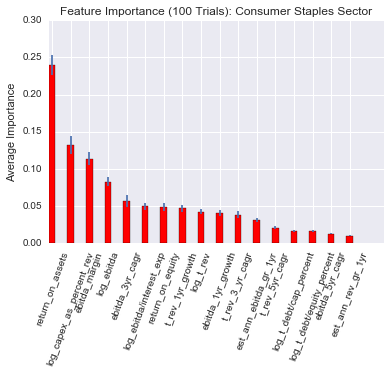

In [38]:
"""
========
Barchart
========

A bar plot with errorbars and height labels on individual bars
"""
import numpy as np
import matplotlib.pyplot as plt

mean_importance = plot_df["mean_importance"]
se = plot_df["se"] * 2

ind = np.arange(len(plot_df))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, mean_importance, width, color='r', yerr=tuple(se))



# add some text for labels, title and axes ticks
ax.set_ylabel('Average Importance')
ax.set_title('Feature Importance (100 Trials): Consumer Staples Sector')
plt.xticks(rotation=70)
ax.set_xticks(ind + width/2)
ax.set_xticklabels(plot_df["feature"])


plt.show()
